<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/7-LSTM/Univariate/univariateLstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LONG SHORT TERM MEMORY


Hafıza bir çok beceri için temel bir gereksinimdir. Detayları ve kritik noktaları hatırlamak kıymetli bir yetenektir. <br>

"Kemal tatilinde Louvre Müzesini gezmiş ve Eiffel kulesinin önünde bolca fotoğraf çekilmiş. Bu gezi onu oldukça eğlendirmiş ve dinlendirmiş gözüküyor. Geldiğinden beri eğlenceli maceralarını anlatıyor. Kısa tatilde tüm şehri gezmek için de epey yol yürümüş. Şehrin tarihi dokusunu onu baya etkilemiş ve yeni şeyler öğrenmiş. Birkaç kelime ______  bile öğrenmiş."  <br>

Boşluğu doldurmak bizim için oldukça kolay. Louvre ve Eiffel bize Kemalin Paris'i ziyaret ettiğini gösteriyor. Ancak bunların kilit kelimeler olduğunu fark etmek ve aklımızda tutmak asıl beceri. Paris'te Fransızcasını ilerlettiğini anlamak, buna kıyasla daha kolay bir görev. <br>

Biz bunu fark etmeden başardık. Peki nasıl oluyor da yapay zeka da bunu başarıyor? <br>

RNNlerde katmalar uyarılıyor ve sonraki katmanları tetikliyorlardı. Bir katmandaki güçlü bir uyaranın etkisi bir kaç sonraki katmanda çok güçlü olmayabiliyor. <br>

LSTMler basitçe katmanlar arası kestirmeler oluşturur. Bu kestirmeler etkisi büyük girdilerin ileri aşamalara taşınarak diğer katmanları da etkilemesi sağlanır. <br>






LSTMler bu hatırlama yapıları sayesinde zaman içinde değişen veriler ile ilgili tahminleri çok iyi yapar. Değişkenler içindeki anlamlı trendleri tespit edip ileriyi tahmin etmek konusunda kullanışlılardır. <br>

Bu örnekte "https://www.kaggle.com/datasets/andreazzini/international-airline-passengers" adresinden alınan uçuş sayıları verilerini kullanarak uçuşların ne zaman artıp azalacağını tahmin etmeyi deneyeceğiz. Uçuş verileri tamamen rastgele değil, tatil zamanları ve havalimanlarının fiyat politikaları gibi arka değişkenlere sahip. Yani içeride bir düzen var. Bunu analiz etmek için ise yapay zeka kullanabiliriz. <br>

# Veriyi elde etmek

Data seti istersen linkten indirebilirsin. Istersen de aşağıdaki kod ile direkt olarak github üzerinden indirmen mümkün. Colab kullanıyorsan aşağıdaki kod ile indirmek daha kolay olacaktır.

In [1]:
!pip install requests -q

In [2]:
import requests

url = "https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/7-LSTM/Univariate/flightData.csv"
response = requests.get(url)

# Save the file
with open("flightData.csv", "wb") as file:
    file.write(response.content)


## Veriyi okumak

Öncelikle genel olarak veriye bakmak adına pandastan gelen info komutunu kullanalım.

In [3]:

import pandas as pd
df = pd.read_csv('flightData.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Bize gereken şey sayılar bu yüzden sadece birinci kolonu alıp artık bunu data set olarak kullanacağız. alttaki iki satırda aynı işlevde istediğini kullanabilirsin.

In [4]:
dataset = df[[df.columns[1]]]
# dataset = df["Passengers"]

Elimizdeki datayı grafik haline getirerek zaman bağlı yolcu sayısı değişimini görelim.

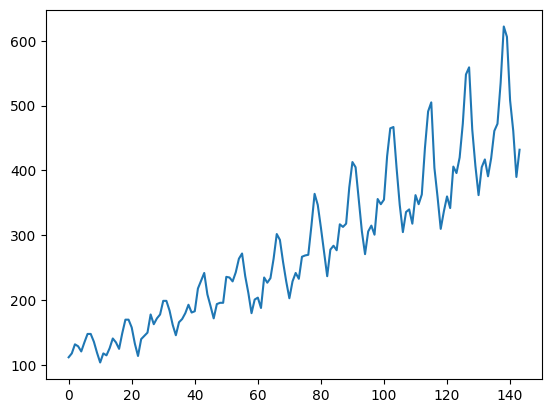

In [5]:

import matplotlib.pyplot as plt

plt.plot(dataset)
plt.show()

Aslında oldukça bariz bir trend var. Ama daha kesin sayı tahminleri için bir lstm kullanalım.

# Tek Değişkene Bağlı bir Ltsm model  Eğitmek


öncesinde bol bol import yapıyoruz.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Ardından tensorflow seedini sabit bir sayı yapalım. Amacımız tekrar edilebilir sonuçlar elde etmek.

In [7]:
tf.random.set_seed(10)

Ardında verimizin uçuş sayıları olan kısımları çekip integer değerleri floata çeviriyoruz. Float çalışmak model eğitmek için daha uygun. Çünkü ondalıklı veriler, integer ile çalışılırken yapılacak değer yuvarlamalarını önler ve gradient descent için yapılan değişimlerin etkilerinin küçükte olsa görünür olmasını sağlar.

In [8]:
# load the dataset
dataframe = pd.read_csv('flightData.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

LTSMler girdi çıktı boyutuna duyarlıdır. Girdilerin belli bir aralığa normalize edilmesi  good practice olarak görlür. Neyse ki bu işlem oldukça kolay. Bunun sebebi aktivasyon fonksiyonlarını model boyunca belli aralıklarda tutmaktır. Çok büyük  ve ya küçük veriler  sürekli olarak 1 ya da 0 sonuçları verecektir.

In [9]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Şimdi eğitim ve test için dataset bölüyoruz. Ama bu sefer data setin sonda yüzde 33 ü test olacak. Burada amaç önceki verilere bakarak gelecek tahmini olduğundan sıralı olarak bölüyoruz. Sınıflandırmalarada rastgele bölüyorduk.

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Amacımız önceki adımlara bakarak sonraki adımları tahmin etmek bunun için bir fonkisyon yazıyoruz. amacımız t zamanındaki yolcu sayısını datax 'e t+1 yani tden bir sonraki zaman aralığındaki sayıyı dataY içine atmak. bu aslında her adımın değişikliğini bir satırda görmek için. <br>


X Y<br>
112 118<br>
118 132<br>
132 129<br>
129 121<br>
121 135<br>

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

Bu fonksiyonu datasette uyguluyoruz.

In [12]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)



LTSM datayı özel bir şekilde ister ->[samples, time steps, features] <br>

bizde ise durum ->  [samples, features] <br>

her adımda ara bir zaman stepi olduğu için araya 1 sayısı ekliyoruz



In [13]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Artık train için hazırız.

1 Görünür giriş ve 4 gizli lstm katmanı var. Tek değerli bir tahmin yapıyor.


In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
94/94 - 3s - 27ms/step - loss: 0.0606
Epoch 2/100
94/94 - 0s - 3ms/step - loss: 0.0322
Epoch 3/100
94/94 - 0s - 3ms/step - loss: 0.0236
Epoch 4/100
94/94 - 0s - 3ms/step - loss: 0.0212
Epoch 5/100
94/94 - 0s - 3ms/step - loss: 0.0202
Epoch 6/100
94/94 - 0s - 3ms/step - loss: 0.0194
Epoch 7/100
94/94 - 0s - 4ms/step - loss: 0.0187
Epoch 8/100
94/94 - 1s - 7ms/step - loss: 0.0179
Epoch 9/100
94/94 - 1s - 7ms/step - loss: 0.0171
Epoch 10/100
94/94 - 1s - 6ms/step - loss: 0.0163
Epoch 11/100
94/94 - 0s - 3ms/step - loss: 0.0155
Epoch 12/100
94/94 - 0s - 3ms/step - loss: 0.0147
Epoch 13/100
94/94 - 0s - 3ms/step - loss: 0.0138
Epoch 14/100
94/94 - 0s - 3ms/step - loss: 0.0130
Epoch 15/100
94/94 - 0s - 3ms/step - loss: 0.0121
Epoch 16/100
94/94 - 0s - 3ms/step - loss: 0.0111
Epoch 17/100
94/94 - 0s - 3ms/step - loss: 0.0102
Epoch 18/100
94/94 - 0s - 3ms/step - loss: 0.0093
Epoch 19/100
94/94 - 0s - 3ms/step - loss: 0.0084
Epoch 20/100
94/94 - 0s - 3ms/step - loss: 0.0075
Epoch 21

## Tahminler yapmak

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Train Score: 23.13 RMSE
Test Score: 47.35 RMSE


Root Mean Squared Error <br>
Train RMSE Skoru: Modelin eğitim verisinde yaptığı hatayı gösterir. <br>
Test RMSE Skoru: Modelin test verisinde yaptığı hatayı gösterir. <br>
Bu iki RMSE skoru, modelin eğitim ve test süreçlerindeki performansını karşılaştırmak için kullanılır. <br> Eğer train RMSE çok düşük, test RMSE ise yüksekse, model aşırı öğrenme (overfitting) yaşıyor olabilir. Her iki skor da düşükse, model iyi bir genelleme yapıyor demektir.

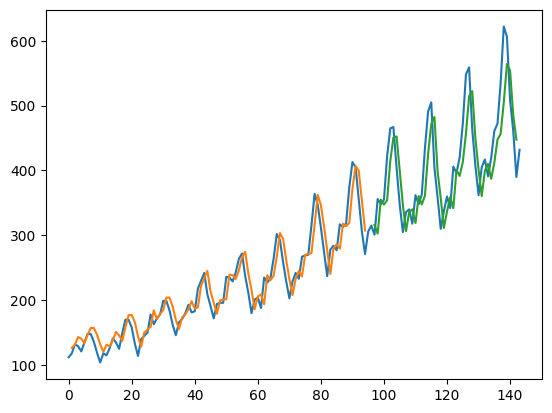

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

144 veri noktası ile çalıştığımızı düşünerek bunun verimli olduğunu söylemek mümkün.